In [2]:
import Pkg; Pkg.add("OptimizationFlux")

    Updating registry at `~/anaconda3/envs/julia_env/share/julia/registries/General.toml`
   Resolving package versions...
   Installed OptimizationFlux ─ v0.1.4
    Updating `~/anaconda3/envs/julia_env/share/julia/environments/julia_env/Project.toml`
  [253f991c] + OptimizationFlux v0.1.4
    Updating `~/anaconda3/envs/julia_env/share/julia/environments/julia_env/Manifest.toml`
  [253f991c] + OptimizationFlux v0.1.4
Precompiling project...
  ✓ OptimizationFlux
  1 dependency successfully precompiled in 13 seconds. 373 already precompiled. 1 skipped during auto due to previous errors.


In [3]:
using DiffEqFlux, Optimization, OptimizationFlux, DifferentialEquations, LinearAlgebra
k, α, β, γ = 1, 0.1, 0.2, 0.3
tspan = (0.0,10.0)

function dxdt_train(du,u,p,t)
  du[1] = u[2]
  du[2] = -k*u[1] - α*u[1]^3 - β*u[2] - γ*u[2]^3
end

u0 = [1.0,0.0]
ts = collect(0.0:0.1:tspan[2])
prob_train = ODEProblem{true}(dxdt_train,u0,tspan)
data_train = Array(solve(prob_train,Tsit5(),saveat=ts))

2×101 Matrix{Float64}:
 1.0   0.994543   0.97839    0.951986  …  -0.260537  -0.249301  -0.235816
 0.0  -0.108662  -0.213651  -0.313419      0.100489   0.12388    0.145526

In [4]:
A = [LegendreBasis(10), LegendreBasis(10)]
nn = TensorLayer(A, 1)

(::TensorLayer{Array{DiffEqFlux.TensorProductBasis}, Vector{Float64}, Int64}) (generic function with 2 methods)

In [5]:
f = x -> min(30one(x),x)

function dxdt_pred(du,u,p,t)
  du[1] = u[2]
  du[2] = -p[1]*u[1] - p[2]*u[2] + f(nn(u,p[3:end])[1])
end

α = zeros(102)

prob_pred = ODEProblem{true}(dxdt_pred,u0,tspan)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 2-element Vector{Float64}:
 1.0
 0.0

In [ ]:
function predict_adjoint(θ)
  x = Array(solve(prob_pred,Tsit5(),p=θ,saveat=ts,
                  sensealg=InterpolatingAdjoint(autojacvec=ReverseDiffVJP(true))))
end

function loss_adjoint(θ)
  x = predict_adjoint(θ)
  loss = sum(norm.(x - data_train))
  return loss
end

In [14]:
# losses = Float64[]

# callback = function (p, l)
#     push!(losses, l)
#     if length(losses) % 50 == 0
#         println("Current loss after $(length(losses)) iterations: $(losses[end])")
#     end
#     return false
# end

losses = Float64[]
iter = 0
function callback(θ,l)
  global iter
  iter += 1
  push!(losses,l)
  if iter%10 == 0
    println(l)
  end
  return false
end

callback (generic function with 1 method)

In [15]:
adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x,p) -> loss_adjoint(x), adtype)
optprob = Optimization.OptimizationProblem(optf, α)
res1 = Optimization.solve(optprob, ADAM(0.05), callback = callback, maxiters = 150)

optprob2 = Optimization.OptimizationProblem(optf, res1.u)
res2 = Optimization.solve(optprob2, ADAM(0.001), callback = callback,maxiters = 150)
opt = res2.u

87.33144565640698
64.46795538575869
54.38356076741718
39.904201765967294
25.99704577834886
16.079462907563986
11.117269701485233
10.799788160634431
9.357020661789198
8.208131272121442
4.970899937875241
4.405635812189562
3.8029026025363875
3.068016018801667
2.6356355522869785
2.5105919355359547
2.4002481322546942
2.3082497794390857
2.2297909693400713
2.159660603346753
2.0973740129964016
2.026849714555241
1.9588423892322386
1.8963974716092031
1.834751521656978
1.7797665150980881
1.7320382132649013
1.687842073613326
1.651133058413818
1.6207510962766838


102-element Vector{Float64}:
  0.4767858967469754
  0.22560574862350735
 -0.0728305442071717
 -0.22560574862350735
  0.10712366343466431
  0.093573095620728
 -0.08044956570687334
 -0.11511618770300014
  0.0728765520585676
  0.29016072589989544
 -0.254624054933547
  0.23212946872187384
 -0.4767858967469754
  ⋮
 -0.26114058508956767
 -0.08122647375612235
 -0.28882194585102816
  0.30607269992309993
  0.29237584772048447
 -0.319393470908298
 -0.29177779034431256
  0.3307137761276962
  0.29665815443967175
 -0.3554487749529624
 -0.29761794636501276
 -0.15673054277323756

In [16]:
losses

302-element Vector{Float64}:
 131.50027796896995
 111.16969123602922
 101.00418078084269
  97.72079510825547
  95.08135774354012
  92.64073105431311
  89.92536105666741
  88.00060717094385
  88.88222913208733
  87.33144565640698
  86.53568017084413
  86.21628626145052
  81.6071274768751
   ⋮
   1.6467019687071505
   1.647028553735332
   1.634443897520069
   1.6289639341196689
   1.6346056631588617
   1.6247856374889333
   1.6294546310736642
   1.6186800422978964
   1.628374594102382
   1.6207510962766838
   1.6091838717125384
   1.6091838717125384

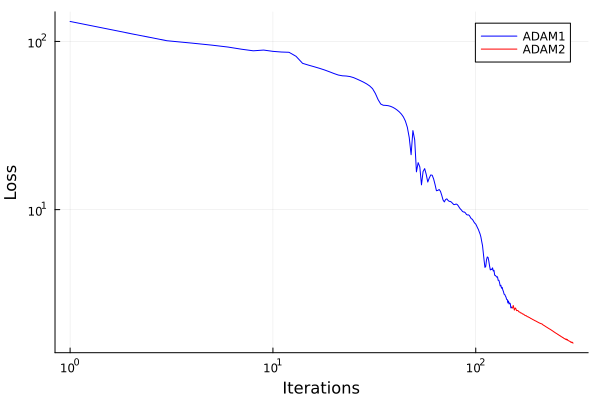

In [21]:
pl_losses = plot(1:151, losses[1:151], yaxis = :log10, xaxis = :log10,
                 xlabel = "Iterations", ylabel = "Loss", label = "ADAM1", color = :blue)
plot!(151:length(losses), losses[151:end], yaxis = :log10, xaxis = :log10,
      xlabel = "Iterations", ylabel = "Loss", label = "ADAM2", color = :red)

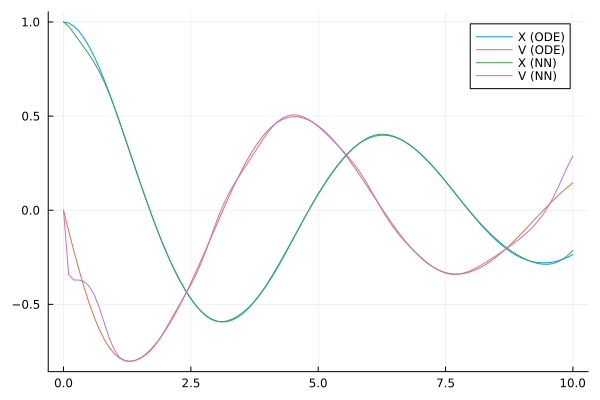

In [8]:
using Plots
data_pred = predict_adjoint(res1.u)
plot(ts, data_train[1,:], label = "X (ODE)")
plot!(ts, data_train[2,:], label = "V (ODE)")
plot!(ts, data_pred[1,:], label = "X (NN)")
plot!(ts, data_pred[2,:],label = "V (NN)")